In [71]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import visualkeras as visualkeras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
import visualkeras

In [44]:
labels_csv = pd.read_csv('labels.csv')
labels_csv["id"] = [fname + ".jpg" for fname in labels_csv["id"]]
data_train = pathlib.Path('train')
data_test = pathlib.Path('test')

In [65]:
batch_size = 16
img_size = 224

In [66]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="validation",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [67]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in vgg16.layers:
    layer.trainable=False

model = Sequential()
model.add(vgg16)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_12 (Bat  (None, 7, 7, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_14  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_37 (Dropout)        (None, 1024)            

In [68]:
history_vgg = model.fit(train_generator, epochs=20, verbose = 1,
                        validation_data=validation_generator)

Epoch 1/20
512/512 [==============================] - 22s 41ms/step - loss: 3.9830 - accuracy: 0.1178 - val_loss: 2.2590 - val_accuracy: 0.4310
Epoch 2/20
512/512 [==============================] - 20s 38ms/step - loss: 2.7589 - accuracy: 0.2858 - val_loss: 1.6654 - val_accuracy: 0.5431
Epoch 3/20
512/512 [==============================] - 20s 38ms/step - loss: 2.4367 - accuracy: 0.3462 - val_loss: 1.5532 - val_accuracy: 0.5749
Epoch 4/20
512/512 [==============================] - 20s 38ms/step - loss: 2.2922 - accuracy: 0.3841 - val_loss: 1.4115 - val_accuracy: 0.6013
Epoch 5/20
512/512 [==============================] - 20s 38ms/step - loss: 2.1366 - accuracy: 0.4126 - val_loss: 1.3981 - val_accuracy: 0.6145
Epoch 6/20
512/512 [==============================] - 19s 38ms/step - loss: 2.0701 - accuracy: 0.4385 - val_loss: 1.3244 - val_accuracy: 0.6233
Epoch 7/20
512/512 [==============================] - 19s 38ms/step - loss: 1.9994 - accuracy: 0.4439 - val_loss: 1.3139 - val_accuracy:

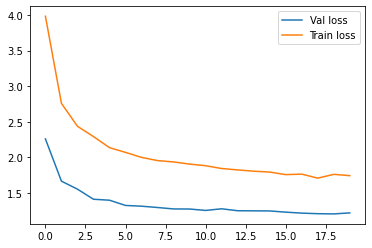

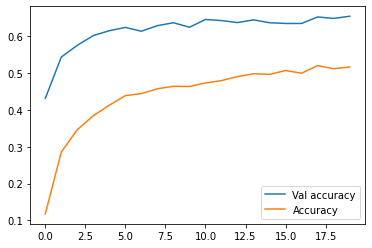

In [69]:
plt.figure()
plt.plot(history_vgg .history["val_loss"], label = "Val loss")
plt.plot(history_vgg .history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_vgg .history["val_accuracy"], label = "Val accuracy")
plt.plot(history_vgg .history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

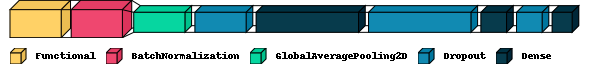

In [74]:
visualkeras.layered_view(model,  legend=True)